In [1]:
from nuisancelib import *
%matplotlib inline

In [2]:
real_files = pd.read_csv('../output/real_output.csv')
real_df = pd.DataFrame(real_files,columns=['Date', 'sid', 'ses', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])

segstats = pd.read_csv('../output/segstats-volume.csv')
seg_df = pd.DataFrame(segstats,columns=['Date', 'sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"])
merged_df = pd.merge(real_df, seg_df, on=['sid', 'ses'], how='outer')
merged_df['Date_x'] = pd.to_datetime(merged_df['Date_x'], format="%Y%m%d")
merged_df.set_index('Date_x',inplace=True)
merged_df

,sid,ses,snr_total,TxRefAmp,AcquisitionTime,SAR,RepetitionTime,Shim1,Shim2,Shim3,...,Right-Accumbens-area,Right-Amygdala,Right-Caudate,Right-Hippocampus,Right-Pallidum,Right-Putamen,Right-Thalamus-Proper,csf,gray,white
Date_x,,,,,,,,,,,,,,,,,,,,,
2016-10-11,sub-sid000003,20161011X092931,12.176199,228.321,34773,0.046610,2.30,4153,-7690,-7492,...,442.968783,1688.027471,3268.476809,3543.750267,1760.800914,4587.099955,7838.965434,292997.718750,8.496853e+05,6.136589e+05
2017-02-14,sub-sid000005,20170214X120812,11.995018,258.474,44480,0.057880,2.30,4153,-7690,-7492,...,635.185595,1718.877083,4169.443674,4436.806975,1953.808741,5039.560927,8996.221381,279086.937500,9.059462e+05,7.412118e+05
2017-08-28,sub-sid000005,20170828X155317,13.083898,257.477,58313,0.059600,2.30,4153,-7690,-7492,...,594.052779,1803.515761,4095.088199,4337.930014,1979.912259,4977.070688,9061.084667,248674.781250,7.889210e+05,6.653368e+05
2017-08-29,sub-sid000005,20170829X171624,13.052024,265.239,62795,0.064612,2.30,4153,-7690,-7492,...,627.275438,1688.027471,4095.088199,4511.162449,1949.853663,5339.355871,9176.572957,281862.593750,8.714904e+05,7.198607e+05
2017-11-18,sub-sid000005,20171118X174426,13.184153,255.721,63930,0.055096,2.30,4146,-7686,-7488,...,621.738328,1703.847785,4100.625309,4282.558916,2001.269682,4947.012092,9038.936228,278994.406250,9.293572e+05,7.293204e+05
2017-02-13,sub-sid000007,20170213X131037,13.696513,253.806,48368,0.053773,2.30,4153,-7690,-7492,...,473.027379,1378.740338,3405.322522,4232.724928,1962.509914,5410.547283,9499.307356,214801.890625,7.374070e+05,6.415477e+05
2017-09-30,sub-sid000007,20170930X101910,12.540846,273.768,37228,0.070596,2.30,4146,-7686,-7488,...,435.849642,1431.738389,3410.068616,4318.945638,1967.256008,5504.678149,9863.965587,258066.468750,8.113044e+05,6.960376e+05
2017-10-04,sub-sid000007,20171004X101244,13.773062,264.229,36827,0.064534,2.30,4146,-7686,-7488,...,488.847693,1539.316522,3390.293224,4352.959312,1933.242333,5604.346125,9555.469470,248599.625000,8.340438e+05,6.870493e+05
2017-11-13,sub-sid000007,20171113X193049,13.851964,271.448,70745,0.068664,2.30,4146,-7686,-7488,...,491.220740,1546.435663,3423.515883,4352.959312,1979.912259,5609.092220,9606.094474,314915.968750,9.380308e+05,8.300230e+05


In [3]:
# df3['Date'] = pd.to_datetime(df3['Date'], format="%Y%m%d")
df3 = pd.read_csv('../data/extractions/anat.csv', parse_dates=['Date'])
df3.set_index('Date',inplace=True)
df_reindexed = df3.reindex(pd.date_range(start=df3.index.min(), end=df3.index.max(), freq='1D'))  
df_reindexed.index.names = ['Date_x']
interpolated_df = df_reindexed.interpolate(method='time')
interpolated_df

,Filetype,snr_total,SAR,AcquisitionTime,TxRefAmp,SoftwareVersions,CSV,RepetitionTime,Shim1,Shim2,...,Shim5,Shim6,Shim7,Shim8,IOPD1,IOPD2,IOPD3,IOPD4,IOPD5,IOPD6
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,acq-MPRAGE_T1w.json,45.609948,0.033092,39009.000000,230.573000,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603
2017-10-31,NaN,46.176395,0.033102,39409.714286,230.703571,NaN,NaN,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596
2017-11-01,NaN,46.742842,0.033112,39810.428571,230.834143,NaN,NaN,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411
2017-11-02,NaN,47.309289,0.033121,40211.142857,230.964714,NaN,NaN,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,0.554171,0.531484,0.138956,-0.122010,0.678457,-0.309418
2017-11-03,NaN,47.875736,0.033131,40611.857143,231.095286,NaN,NaN,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425
2017-11-04,NaN,48.442183,0.033141,41012.571429,231.225857,NaN,NaN,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,0.272647,0.742449,0.220246,-0.060225,0.490009,-0.631432
2017-11-05,NaN,49.008630,0.033150,41413.285714,231.356429,NaN,NaN,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439
2017-11-06,acq-MPRAGE_T1w.json,49.575077,0.033160,41814.000000,231.487000,syngo_MR_E11,v1.0.20171215 (OpenJPEG build) GCC6.3.0,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,-0.008877,0.953414,0.301535,0.001560,0.301560,-0.953446
2017-11-07,NaN,49.251327,0.033173,41217.428571,231.464000,NaN,NaN,2.3,4146.0,-7686.0,...,-55.0,-88.0,-63.0,64.0,-0.028902,0.951493,0.302313,-0.007970,0.301400,-0.953178


In [4]:
super_df = pd.merge(merged_df, interpolated_df, left_index=True, right_index=True, suffixes = ("_real", "_qa"))
super_df

,sid,ses,snr_total_real,TxRefAmp_real,AcquisitionTime_real,SAR_real,RepetitionTime_real,Shim1_real,Shim2_real,Shim3_real,...,Shim5_qa,Shim6_qa,Shim7_qa,Shim8_qa,IOPD1_qa,IOPD2_qa,IOPD3_qa,IOPD4_qa,IOPD5_qa,IOPD6_qa
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,sub-sid000496,20171030X191622,11.073170,301.097,69686,0.053360,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603
2017-10-30,sub-sid000671,20171030X201904,13.257334,239.409,73440,0.056120,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603
2017-10-31,sub-sid000013,20171031X200034,12.908929,228.607,72731,0.047360,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596
2017-11-01,sub-sid000009,20171101X195906,12.986074,246.713,72619,0.055586,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411
2017-11-03,sub-sid000677,20171103X190009,11.148881,244.822,68937,0.057679,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425
2017-11-03,sub-sid000678,20171103X200909,14.231328,226.757,73221,0.051241,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425
2017-11-05,sub-sid000024,20171105X200345,12.615811,268.301,72794,0.058591,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439
2017-11-05,sub-sid000494,20171105X121747,13.041954,250.491,44508,0.065390,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439
2017-11-05,sub-sid000679,20171105X100749,11.297897,226.806,36978,0.056067,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439


In [5]:
demographic_df = pd.read_csv('../data/dbic/bids/participants.tsv', sep='\t')
demographic_df = demographic_df.rename(index=str, columns={"participant_id": "sid"})
final_df = super_df.join(demographic_df.set_index('sid'), on='sid', how='left')
final_df

,sid,ses,snr_total_real,TxRefAmp_real,AcquisitionTime_real,SAR_real,RepetitionTime_real,Shim1_real,Shim2_real,Shim3_real,...,Shim7_qa,Shim8_qa,IOPD1_qa,IOPD2_qa,IOPD3_qa,IOPD4_qa,IOPD5_qa,IOPD6_qa,age,sex
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,sub-sid000496,20171030X191622,11.073170,301.097,69686,0.053360,2.3,4146,-7686,-7488,...,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,18,M
2017-10-30,sub-sid000671,20171030X201904,13.257334,239.409,73440,0.056120,2.3,4146,-7686,-7488,...,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,19,M
2017-10-31,sub-sid000013,20171031X200034,12.908929,228.607,72731,0.047360,2.3,4146,-7686,-7488,...,-63.0,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596,27,F
2017-11-01,sub-sid000009,20171101X195906,12.986074,246.713,72619,0.055586,2.3,4146,-7686,-7488,...,-63.0,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411,27,M
2017-11-03,sub-sid000677,20171103X190009,11.148881,244.822,68937,0.057679,2.3,4146,-7686,-7488,...,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,19,F
2017-11-03,sub-sid000678,20171103X200909,14.231328,226.757,73221,0.051241,2.3,4146,-7686,-7488,...,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,21,F
2017-11-05,sub-sid000024,20171105X200345,12.615811,268.301,72794,0.058591,2.3,4146,-7686,-7488,...,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,31,M
2017-11-05,sub-sid000494,20171105X121747,13.041954,250.491,44508,0.065390,2.3,4146,-7686,-7488,...,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,18,F
2017-11-05,sub-sid000679,20171105X100749,11.297897,226.806,36978,0.056067,2.3,4146,-7686,-7488,...,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,19,F


In [6]:
# need to slice a prepared DataFrame first
real_data_df = pd.DataFrame(final_df,columns=['gray', 'age', 'sex', 'snr_total_qa'])
real_data_df = real_data_df.reset_index()
real_data_df = real_data_df.rename(columns={'Date_x': 'Date'})
real_data_df['sind'] = [0 for item in range(len(real_data_df))]
real_data_df.sind[real_data_df.sex == 'M'] = int(1)
real_data_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,gray,age,sex,snr_total_qa,sind
0,2017-10-30,8.646347e+05,18,M,45.609948,1
1,2017-10-30,7.388941e+05,19,M,45.609948,1
2,2017-10-31,6.797624e+05,27,F,46.176395,0
3,2017-11-01,7.363858e+05,27,M,46.742842,1
4,2017-11-03,6.829566e+05,19,F,47.875736,0
5,2017-11-03,5.824921e+05,21,F,47.875736,0
6,2017-11-05,7.327099e+05,31,M,49.008630,1
7,2017-11-05,1.023724e+06,18,F,49.008630,0
8,2017-11-05,7.930209e+05,19,F,49.008630,0
9,2017-11-05,8.361739e+05,19,M,49.008630,1


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


No Shim variables in the model
No IOPD variables in the model
Seasonal F-test: <F test: F=array([[6.67075489]]), p=0.0015002754097003734, df_denom=255, df_num=2>
Statistically significant variables: ['const', 'age', 'snr_total_qa', 'sind', 'Seasonal (sin)', 'Seasonal (cos)']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     7.686
Date:                Mon, 14 Oct 2019   Prob (F-statistic):           9.48e-07
Time:                        16:30:42   Log-Likelihood:                -3527.1
No. Observations:                 261   AIC:                             7066.
Df Residuals:                     255   BIC:                             7088.
Df Model:                           5                                         
Covariance Ty

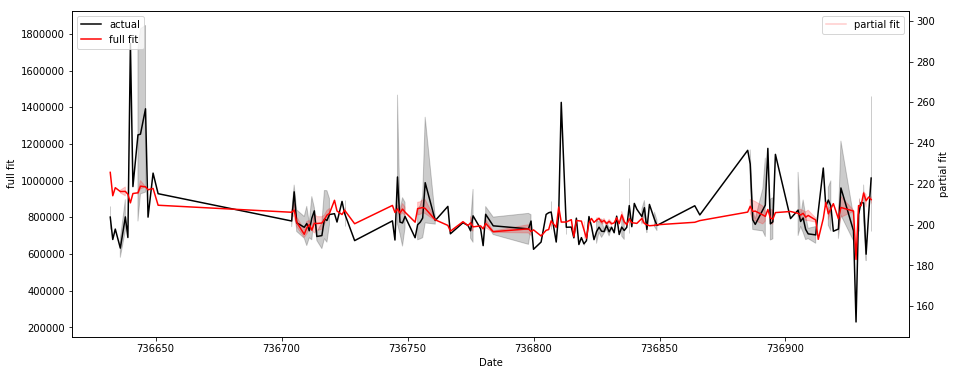

In [7]:
regress('gray', real_data_df, qa=False)

/Users/chrischeng/nuisance/ipy/nuisancelib.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['Seasonal (sin)'] = np.sin(time_delta_rad)
/Users/chrischeng/nuisance/ipy/nuisancelib.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['Seasonal (cos)'] = np.cos(time_delta_rad)
/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


No Shim variables in the model
No IOPD variables in the model
Seasonal F-test: <F test: F=array([[2.20551376]]), p=0.11251921859258096, df_denom=230, df_num=2>
Statistically significant variables: ['const', 'age', 'snr_total_qa', 'sind']
                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     7.352
Date:                Mon, 14 Oct 2019   Prob (F-statistic):           2.05e-06
Time:                        16:30:45   Log-Likelihood:                -3132.0
No. Observations:                 236   AIC:                             6276.
Df Residuals:                     230   BIC:                             6297.
Df Model:                           5                                         
Covariance Type:            nonrobust              

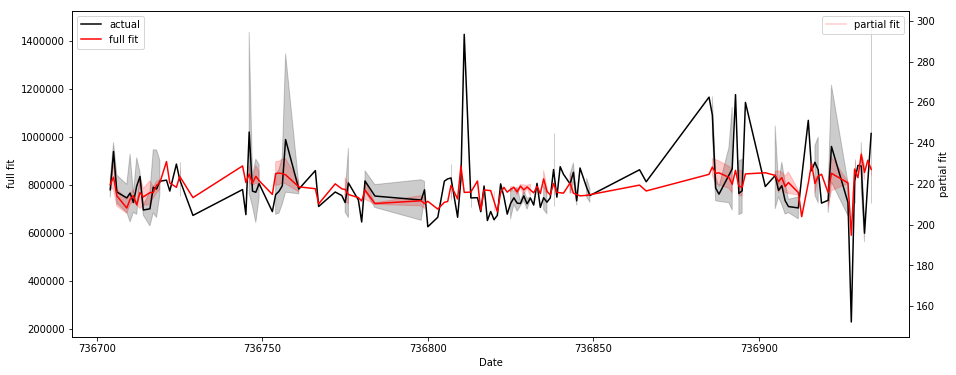

In [8]:
regress('gray', real_data_df.loc[25:], qa=False)

In [9]:
# 'Background', "Left-Accumbens-area", 
#                                         "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
#                                         "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
#                                         "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
#                                         "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"
amyg_data_df = pd.DataFrame(final_df,columns=['csf', 'age', 'sex', 'snr_total_qa'])
amyg_data_df = amyg_data_df.reset_index()
amyg_data_df = amyg_data_df.rename(columns={'Date_x': 'Date'})
amyg_data_df['sind'] = [0 for item in range(len(amyg_data_df))]
amyg_data_df.sind[amyg_data_df.sex == 'M'] = int(1)
amyg_data_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Date,csf,age,sex,snr_total_qa,sind
0,2017-10-30,264707.875000,18,M,45.609948,1
1,2017-10-30,234300.421875,19,M,45.609948,1
2,2017-10-31,218291.046875,27,F,46.176395,0
3,2017-11-01,255414.984375,27,M,46.742842,1
4,2017-11-03,549233.812500,19,F,47.875736,0
5,2017-11-03,213185.031250,21,F,47.875736,0
6,2017-11-05,224194.390625,31,M,49.008630,1
7,2017-11-05,505816.531250,18,F,49.008630,0
8,2017-11-05,242355.328125,19,F,49.008630,0
9,2017-11-05,309665.250000,19,M,49.008630,1


In [10]:
expanded_df = pd.DataFrame(final_df,columns=['sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white", 'age', 
                                             'sex', 'snr_total_qa', 'IOPD1_real', 'IOPD2_real', 'IOPD3_real', 
                                             'IOPD4_real', 'IOPD5_real', 'IOPD6_real'])
expanded_df = expanded_df.reset_index()
expanded_df = expanded_df.rename(columns={'Date_x': 'Date'})
expanded_df['sind'] = [0 for item in range(len(expanded_df))]
expanded_df.sind[expanded_df.sex == 'M'] = int(1)
expanded_df

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Date,sid,ses,Background,Left-Accumbens-area,Left-Amygdala,Left-Caudate,Left-Hippocampus,Left-Pallidum,Left-Putamen,...,age,sex,snr_total_qa,IOPD1_real,IOPD2_real,IOPD3_real,IOPD4_real,IOPD5_real,IOPD6_real,sind
0,2017-10-30,sub-sid000496,20171030X191622,9.897986e+06,455.625034,1672.998173,4100.625309,4080.058901,1905.556784,6025.166470,...,18,M,45.609948,0.015692,0.981912,0.188687,0.029789,0.188168,-0.981685,1
1,2017-10-30,sub-sid000671,20171030X201904,9.902218e+06,671.572316,1286.982519,3906.035451,3894.170215,1834.365373,5393.935953,...,19,M,45.609948,-0.003661,0.956858,0.290532,-0.006154,0.290507,-0.956853,1
2,2017-10-31,sub-sid000013,20171031X200034,9.908312e+06,524.443399,1323.369240,4018.359678,3653.701447,1657.968875,4594.219096,...,27,F,46.176395,0.010975,0.963201,0.268559,0.017243,0.268352,-0.963166,0
3,2017-11-01,sub-sid000009,20171101X195906,9.893464e+06,751.464900,1353.427836,4835.478880,4617.949567,1888.945455,5674.746521,...,27,M,46.742842,-0.024720,0.997518,0.065923,0.007328,0.066122,-0.997785,1
4,2017-11-03,sub-sid000677,20171103X190009,9.906060e+06,535.517618,1575.703244,4052.373352,3122.138907,1821.709122,4542.012061,...,19,F,47.875736,-0.103218,0.965742,0.238093,-0.087405,0.229639,-0.969343,0
5,2017-11-03,sub-sid000678,20171103X200909,9.902156e+06,457.998081,1612.089965,4208.994458,4040.508117,1863.632953,5116.289448,...,21,F,47.875736,-0.072749,0.946123,0.315529,-0.068830,0.310850,-0.947963,0
6,2017-11-05,sub-sid000024,20171105X200345,9.895909e+06,715.869195,1942.734521,4447.881195,4176.562815,2118.340003,5669.209412,...,31,M,49.008630,-0.046898,0.977565,0.205346,-0.016547,0.204783,-0.978667,1
7,2017-11-05,sub-sid000494,20171105X121747,9.901622e+06,507.041054,1556.718867,4288.096026,3478.886981,1897.646627,5147.930075,...,18,F,49.008630,0.017341,0.989923,0.140544,0.015694,0.140278,-0.989988,0
8,2017-11-05,sub-sid000679,20171105X100749,9.905068e+06,474.609411,1152.509852,3784.219035,3972.480768,1766.338024,4536.474951,...,19,F,49.008630,0.084958,0.962994,0.255782,0.025266,0.254546,-0.966731,0
9,2017-11-05,sub-sid000680,20171105X111450,9.899460e+06,541.054728,1852.558733,4673.320665,3877.558886,2085.117345,5586.152765,...,19,M,49.008630,0.046288,0.987757,0.148973,0.094500,0.144134,-0.985036,1


In [11]:
df = pd.read_csv('../data/extractions/p2_BOLD.csv', parse_dates=['Date'])
tsnr_df = pd.DataFrame(df,columns=['Date', 'tsnr'])
tsnr_df.set_index('Date',inplace=True)
tsnr_df_reindexed = tsnr_df.reindex(pd.date_range(start=tsnr_df.index.min(), end=tsnr_df.index.max(), freq='1D'))  
tsnr_df_reindexed.index.names = ['Date']
interpolated_tsnr_df = tsnr_df_reindexed.interpolate(method='time')
interpolated_tsnr_df

new_df = pd.merge(interpolated_tsnr_df, expanded_df, on=['Date'], how='right')
new_df

,Date,tsnr,sid,ses,Background,Left-Accumbens-area,Left-Amygdala,Left-Caudate,Left-Hippocampus,Left-Pallidum,...,age,sex,snr_total_qa,IOPD1_real,IOPD2_real,IOPD3_real,IOPD4_real,IOPD5_real,IOPD6_real,sind
0,2017-10-30,180.321930,sub-sid000496,20171030X191622,9.897986e+06,455.625034,1672.998173,4100.625309,4080.058901,1905.556784,...,18,M,45.609948,0.015692,0.981912,0.188687,0.029789,0.188168,-0.981685,1
1,2017-10-30,180.321930,sub-sid000671,20171030X201904,9.902218e+06,671.572316,1286.982519,3906.035451,3894.170215,1834.365373,...,19,M,45.609948,-0.003661,0.956858,0.290532,-0.006154,0.290507,-0.956853,1
2,2017-10-31,189.864031,sub-sid000013,20171031X200034,9.908312e+06,524.443399,1323.369240,4018.359678,3653.701447,1657.968875,...,27,F,46.176395,0.010975,0.963201,0.268559,0.017243,0.268352,-0.963166,0
3,2017-11-01,199.406132,sub-sid000009,20171101X195906,9.893464e+06,751.464900,1353.427836,4835.478880,4617.949567,1888.945455,...,27,M,46.742842,-0.024720,0.997518,0.065923,0.007328,0.066122,-0.997785,1
4,2017-11-03,218.490335,sub-sid000677,20171103X190009,9.906060e+06,535.517618,1575.703244,4052.373352,3122.138907,1821.709122,...,19,F,47.875736,-0.103218,0.965742,0.238093,-0.087405,0.229639,-0.969343,0
5,2017-11-03,218.490335,sub-sid000678,20171103X200909,9.902156e+06,457.998081,1612.089965,4208.994458,4040.508117,1863.632953,...,21,F,47.875736,-0.072749,0.946123,0.315529,-0.068830,0.310850,-0.947963,0
6,2017-11-05,237.574537,sub-sid000024,20171105X200345,9.895909e+06,715.869195,1942.734521,4447.881195,4176.562815,2118.340003,...,31,M,49.008630,-0.046898,0.977565,0.205346,-0.016547,0.204783,-0.978667,1
7,2017-11-05,237.574537,sub-sid000494,20171105X121747,9.901622e+06,507.041054,1556.718867,4288.096026,3478.886981,1897.646627,...,18,F,49.008630,0.017341,0.989923,0.140544,0.015694,0.140278,-0.989988,0
8,2017-11-05,237.574537,sub-sid000679,20171105X100749,9.905068e+06,474.609411,1152.509852,3784.219035,3972.480768,1766.338024,...,19,F,49.008630,0.084958,0.962994,0.255782,0.025266,0.254546,-0.966731,0
9,2017-11-05,237.574537,sub-sid000680,20171105X111450,9.899460e+06,541.054728,1852.558733,4673.320665,3877.558886,2085.117345,...,19,M,49.008630,0.046288,0.987757,0.148973,0.094500,0.144134,-0.985036,1


In [12]:
dicom_data = pd.read_csv('../output/dicom_data.csv')
dicom_data = pd.DataFrame(dicom_data,columns=['sid', 'ses', 'PatientWeight'])
July17_df = pd.merge(new_df, dicom_data, on=['sid', 'ses'], how='left')
July17_df

,Date,tsnr,sid,ses,Background,Left-Accumbens-area,Left-Amygdala,Left-Caudate,Left-Hippocampus,Left-Pallidum,...,sex,snr_total_qa,IOPD1_real,IOPD2_real,IOPD3_real,IOPD4_real,IOPD5_real,IOPD6_real,sind,PatientWeight
0,2017-10-30,180.321930,sub-sid000496,20171030X191622,9.897986e+06,455.625034,1672.998173,4100.625309,4080.058901,1905.556784,...,M,45.609948,0.015692,0.981912,0.188687,0.029789,0.188168,-0.981685,1,131.541804
1,2017-10-30,180.321930,sub-sid000671,20171030X201904,9.902218e+06,671.572316,1286.982519,3906.035451,3894.170215,1834.365373,...,M,45.609948,-0.003661,0.956858,0.290532,-0.006154,0.290507,-0.956853,1,64.410125
2,2017-10-31,189.864031,sub-sid000013,20171031X200034,9.908312e+06,524.443399,1323.369240,4018.359678,3653.701447,1657.968875,...,F,46.176395,0.010975,0.963201,0.268559,0.017243,0.268352,-0.963166,0,56.699053
3,2017-11-01,199.406132,sub-sid000009,20171101X195906,9.893464e+06,751.464900,1353.427836,4835.478880,4617.949567,1888.945455,...,M,46.742842,-0.024720,0.997518,0.065923,0.007328,0.066122,-0.997785,1,70.306826
4,2017-11-03,218.490335,sub-sid000677,20171103X190009,9.906060e+06,535.517618,1575.703244,4052.373352,3122.138907,1821.709122,...,F,47.875736,-0.103218,0.965742,0.238093,-0.087405,0.229639,-0.969343,0,63.502940
5,2017-11-03,218.490335,sub-sid000678,20171103X200909,9.902156e+06,457.998081,1612.089965,4208.994458,4040.508117,1863.632953,...,F,47.875736,-0.072749,0.946123,0.315529,-0.068830,0.310850,-0.947963,0,52.616722
6,2017-11-05,237.574537,sub-sid000024,20171105X200345,9.895909e+06,715.869195,1942.734521,4447.881195,4176.562815,2118.340003,...,M,49.008630,-0.046898,0.977565,0.205346,-0.016547,0.204783,-0.978667,1,84.368192
7,2017-11-05,237.574537,sub-sid000494,20171105X121747,9.901622e+06,507.041054,1556.718867,4288.096026,3478.886981,1897.646627,...,F,49.008630,0.017341,0.989923,0.140544,0.015694,0.140278,-0.989988,0,63.502940
8,2017-11-05,237.574537,sub-sid000679,20171105X100749,9.905068e+06,474.609411,1152.509852,3784.219035,3972.480768,1766.338024,...,F,49.008630,0.084958,0.962994,0.255782,0.025266,0.254546,-0.966731,0,52.163129
9,2017-11-05,237.574537,sub-sid000680,20171105X111450,9.899460e+06,541.054728,1852.558733,4673.320665,3877.558886,2085.117345,...,M,49.008630,0.046288,0.987757,0.148973,0.094500,0.144134,-0.985036,1,86.182561


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


No Shim variables in the model
IOPD F-test: <F test: F=array([[1.2063734]]), p=0.3034673802791006, df_denom=248, df_num=6>
Seasonal F-test: <F test: F=array([[1.63197807]]), p=0.19763526250332197, df_denom=248, df_num=2>
Statistically significant variables: ['const', 'snr_total_qa', 'IOPD3_real', 'IOPD5_real', 'PatientWeight']
                            OLS Regression Results                            
Dep. Variable:                    csf   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     3.591
Date:                Mon, 14 Oct 2019   Prob (F-statistic):           5.89e-05
Time:                        16:39:46   Log-Likelihood:                -3281.6
No. Observations:                 261   AIC:                             6589.
Df Residuals:                     248   BIC:                             6635.
Df Model:                          12  

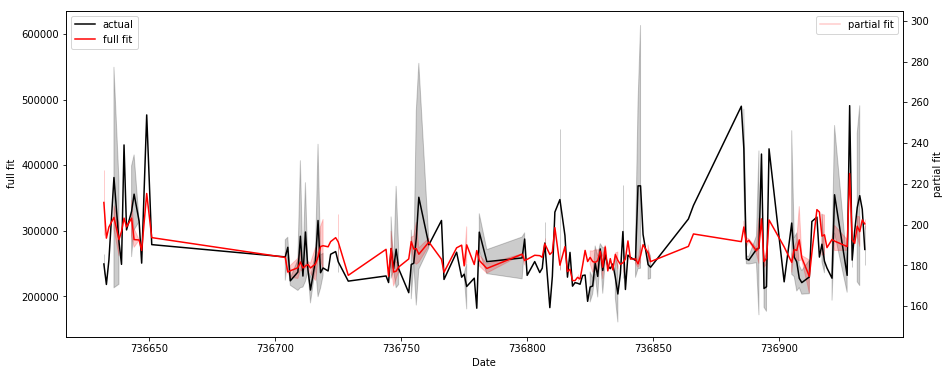

In [19]:
Oct14_df = pd.DataFrame(July17_df,columns=['Date', 'csf', 'age', 'snr_total_qa', 'IOPD1_real', 'IOPD2_real', 'IOPD3_real', 
                                              'IOPD4_real', 'IOPD5_real', 'IOPD6_real', 'sind', 'PatientWeight', 
                                              'Seasonal (sin)', 'Seasonal (cos)'])
hello = regress('csf', Oct14_df, qa=False)

In [15]:
targets = ['Background', "Left-Accumbens-area", "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"]
scrape_var_significance(targets, 'snr_total_qa', July17_df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


,Variable,snr_total_qa p value,R2 value
0,Background,0.259286,0.471313
1,Left-Accumbens-area,0.995750,0.104321
2,Left-Amygdala,0.405325,0.330284
3,Left-Caudate,0.110944,0.219234
4,Left-Hippocampus,0.320920,0.218041
5,Left-Pallidum,0.576059,0.521950
6,Left-Putamen,0.461739,0.270311
7,Left-Thalamus-Proper,0.260049,0.431581
8,Right-Accumbens-area,0.399768,0.149502
9,Right-Amygdala,0.525882,0.335799


In [16]:
scrape_var_significance(targets, 'Seasonal (sin)', July17_df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


,Variable,Seasonal (sin) p value,R2 value
0,Background,0.227563,0.471313
1,Left-Accumbens-area,0.455503,0.104321
2,Left-Amygdala,0.203825,0.330284
3,Left-Caudate,0.374273,0.219234
4,Left-Hippocampus,0.421946,0.218041
5,Left-Pallidum,0.030493,0.521950
6,Left-Putamen,0.095848,0.270311
7,Left-Thalamus-Proper,0.227858,0.431581
8,Right-Accumbens-area,0.177904,0.149502
9,Right-Amygdala,0.735377,0.335799
